# SQL Analysis Development Notebook

This notebook is used for testing code concepts for the SQL Analysis module.

## Table of Contents

<ol>
    <li><a href='#start'>Modifying Class Dictionary</a></li>
    <li><a href='#create'>Create Tables</a></li>
    <li><a href='#test'>Test Functionality</a></li>
    <li><a href='#summary'>Summarize Function</a></li>
    <li><a href='#compare'>Compare IDs</a></li>
    <li><a href='#string'>Create Test String</a></li>
    <li><a href='#tables'>Compare Tables</a></li>
    <li><a href='#input'>Input Tests</a></li>
    <li><a href='#detect'>Detect Type</a></li>
    <li><a href='#update'>Update Attributes</a></li>
    <li><a href='#custom'>Customize Test String</a></li>
</ol>

In [5]:
from collections import namedtuple
from importlib import reload

import numpy as np
import pandas as pd
from sqlalchemy import types
import seaborn as sns
import matplotlib.pyplot as plt

import sql_test as st
from sql_test.sql_config import ENGINE_DVD
import sql_test.sql_input_tests as sqlit

%matplotlib inline

<a id='start'></a>
## Modifying Class Dictionary

In [1]:
class DictTest:
    def __init__(self):
        self.my_dict = {}
        self.label = 'count'
    
    def run_test(self, value):
        if value > 10:
            self.my_dict[self.label] = value

In [2]:
tester = DictTest()

my_list = [1, 15, 6, 8, 20, 13]
my_labels = ['abc', 'xyz', 'def', 'lmn', 'ijk', 'str']

for value, label in zip(my_list, my_labels):
    tester.label = label
    tester.run_test(value)

In [3]:
tester.my_dict

{'xyz': 15, 'ijk': 20, 'str': 13}

<a id='create'></a>
## Create Tables

In [148]:
create_str = "\
SELECT \
    CAST(EXTRACT(YEAR FROM r.rental_date) AS TEXT) || '-' ||  CAST(EXTRACT(MONTH FROM r.rental_date) AS TEXT) AS ss_dt \
    , r.rental_id \
    , r.rental_date \
    , f.title \
    , f.length \
    , f.rating \
FROM rental r \
    JOIN inventory i \
        ON i.inventory_id = r.inventory_id \
    JOIN film f \
        ON f.film_id = i.film_id"

df = san.sql_query(create_str, 'dvd')

In [30]:
df.head()

,ss_dt,rental_id,rental_date,title,length,rating
0,2005-5,2,2005-05-24 22:54:33,Freaky Pocus,126,R
1,2005-5,3,2005-05-24 23:03:39,Graduate Lord,156,G
2,2005-5,4,2005-05-24 23:04:41,Love Suicides,181,R
3,2005-5,5,2005-05-24 23:05:21,Idols Snatchers,84,NC-17
4,2005-5,6,2005-05-24 23:08:07,Mystic Truman,92,NC-17


In [19]:
df.rental_date.describe()

count                   16044
unique                  15815
top       2006-02-14 15:16:03
freq                      182
first     2005-05-24 22:53:30
last      2006-02-14 15:16:03
Name: rental_date, dtype: object

Generate random timestamps via this [StackOverflow answer](https://stackoverflow.com/questions/553303/generate-a-random-date-between-two-other-dates).

In [20]:
from random import randrange
from datetime import timedelta

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

In [23]:
random_dates = []
for _ in np.arange(df.shape[0]):
    random_dates.append(random_date(df.rental_date.min(),
                                    df.rental_date.max()))

Create alternate view for comparison testing.

In [31]:
alt_rental_view = df.copy()
alt_rental_view['rental_date'] = random_dates
alt_rental_view['ss_date'] = alt_rental_view['rental_date'].dt.year.astype(str) \
                             + '-' + alt_rental_view['rental_date'].dt.month.astype(str)
alt_rental_view.drop('ss_dt', axis=1, inplace=True)

In [32]:
alt_rental_view.head()

,rental_id,rental_date,title,length,rating,ss_date
0,2,2005-12-02 22:58:47,Freaky Pocus,126,R,2005-12
1,3,2005-11-04 04:06:39,Graduate Lord,156,G,2005-11
2,4,2005-10-08 19:37:49,Love Suicides,181,R,2005-10
3,5,2005-09-03 13:17:21,Idols Snatchers,84,NC-17,2005-9
4,6,2005-10-31 02:40:27,Mystic Truman,92,NC-17,2005-10


Create tables in database

In [39]:
alt_rental_view.to_sql('alt_rental_view', 
                       ENGINE_DVD, 
                       if_exists='replace', 
                       index=False,
                       dtype={"rental_id": types.Integer(),
                              "rental_date": types.Date(),
                              "title": types.VARCHAR(length=255),
                              "length": types.Integer(),
                              "rating": types.VARCHAR(length=6),
                              "ss_date": types.VARCHAR(length=8)})

In [41]:
df.to_sql('rental_view',
          ENGINE_DVD,
          if_exists='replace',
          dtype={"rental_id": types.Integer(),
                 "ss_dt": types.VARCHAR(length=8),
                 "rental_date": types.Date(),
                 "title": types.VARCHAR(length=255),
                 "length": types.Integer(),
                 "rating": types.VARCHAR(length=6)})

Create a third test table.

In [150]:
df.shape

(16044, 6)

In [151]:
drop_ind = np.random.randint(0, df.shape[0], 200)

In [152]:
alt_sim_rental_view = df.drop(drop_ind).copy()

In [155]:
df.columns

Index(['ss_dt', 'rental_id', 'rental_date', 'title', 'length', 'rating'], dtype='object')

In [156]:
alt_sim_rental_view.columns = ['ss_dt', 'id', 'rental_date', 'movie', 'runtime', 'rating']
alt_sim_rental_view.to_sql('alt_sim_rental_view',
                           ENGINE_DVD,
                           if_exists='replace',
                           index=False,
                           dtype={"ss_dt": types.VARCHAR(length=8),
                                  "id": types.Integer(),
                                  "rental_date": types.Date(),
                                  "movie": types.VARCHAR(length=255),
                                  "runtime": types.Integer(),
                                  "rating": types.VARCHAR(length=6)})

<a id='test'></a>
## Test Functionality

In [4]:
rental_view = st.sql_query('SELECT * FROM rental_view', 'dvd')
rental_view.head()

,index,ss_dt,rental_id,rental_date,title,length,rating
0,0,2005-5,2,2005-05-24,Freaky Pocus,126,R
1,1,2005-5,3,2005-05-24,Graduate Lord,156,G
2,2,2005-5,4,2005-05-24,Love Suicides,181,R
3,3,2005-5,5,2005-05-24,Idols Snatchers,84,NC-17
4,4,2005-5,6,2005-05-24,Mystic Truman,92,NC-17


In [5]:
alt_rental_view = st.sql_query('SELECT * FROM alt_rental_view', 'dvd')
alt_rental_view.head()

,rental_id,rental_date,title,length,rating,ss_date
0,2,2005-12-02,Freaky Pocus,126,R,2005-12
1,3,2005-11-04,Graduate Lord,156,G,2005-11
2,4,2005-10-08,Love Suicides,181,R,2005-10
3,5,2005-09-03,Idols Snatchers,84,NC-17,2005-9
4,6,2005-10-31,Mystic Truman,92,NC-17,2005-10


In [6]:
alt_sim_rental_view = st.sql_query('SELECT * FROM alt_sim_rental_view', 'dvd')
alt_sim_rental_view.head()

,ss_dt,id,rental_date,movie,runtime,rating
0,2005-5,2,2005-05-24,Freaky Pocus,126,R
1,2005-5,3,2005-05-24,Graduate Lord,156,G
2,2005-5,4,2005-05-24,Love Suicides,181,R
3,2005-5,5,2005-05-24,Idols Snatchers,84,NC-17
4,2005-5,6,2005-05-24,Mystic Truman,92,NC-17


In [71]:
reload(san);

In [44]:
# Specify table fields - "target" table is first
comparison_fields = ('rental_id','rental_id', 'id')
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')

# Create data gatherer
tester = san.SQLUnitTest(comparison_fields,
                         groupby_fields,
                         table_names,
                         table_alias,
                         db_server='dvd',
                         test_type='count')

tester.run_test()
tester._results

Commencing test for count rental_id...
   Commencing rental_id query...
   Query for rental_id complete.
PRIORITY REVIEW on alt_rental_id: 67.73
Test for rental_id complete.



,date,ss_dt,rvw_count,alt_count,sim_count,rvw_minus_alt,perc_diff_alt,rvw_minus_sim,perc_diff_sim
0,04-Aug-19,2005-5,1156,417,1140,739,63.93,16,1.38
1,04-Aug-19,2005-6,2311,1856,2287,455,19.69,24,1.04
2,04-Aug-19,2005-7,6709,1795,6630,4914,73.24,79,1.18
3,04-Aug-19,2005-8,5686,1835,5610,3851,67.73,76,1.34
4,04-Aug-19,2006-2,182,857,179,-675,-370.88,3,1.65


In [25]:
# Specify table fields - "target" table is first
comparison_fields = ('rental_id','rental_id', 'id')
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')

# Create data gatherer
tester = san.SQLUnitTest(comparison_fields,
                         groupby_fields,
                         table_names,
                         table_alias,
                         db_server='dvd',
                         test_type='count')

# Get data for 'count' test
count_df = tester.gather_data()
count_df

Commencing rental_id query...
Query for rental_id complete.



,ss_dt,rvw_count,alt_count,sim_count
0,2005-5,1156,417,1140
1,2005-6,2311,1856,2287
2,2005-7,6709,1795,6630
3,2005-8,5686,1835,5610
4,2006-2,182,857,179


In [26]:
tester.run_test()
tester._results

Commencing test for rental_id...
Commencing rental_id query...
Query for rental_id complete.

PRIORITY REVIEW on alt_rental_id: 67.73
Test for rental_id complete.



,date,ss_dt,rvw_count,alt_count,sim_count,rvw_minus_alt,perc_diff_alt,rvw_minus_sim,perc_diff_sim
0,04-Aug-19,2005-5,1156,417,1140,739,63.93,16,1.38
1,04-Aug-19,2005-6,2311,1856,2287,455,19.69,24,1.04
2,04-Aug-19,2005-7,6709,1795,6630,4914,73.24,79,1.18
3,04-Aug-19,2005-8,5686,1835,5610,3851,67.73,76,1.34
4,04-Aug-19,2006-2,182,857,179,-675,-370.88,3,1.65


In [30]:
tester._results['perc_diff_alt'] = np.nan
tester._assess_priority_review('rating', 'perc_diff_alt', 2)

MISSING VALUE for rating_rating


'MISSING VALUE for rating_rating'

In [66]:
reload(st);

In [67]:
# Specify table fields 
comparison_fields = ('rental_id','rental_id')
groupby_fields = ('ss_dt', 'ss_date')
table_names = ('rental_view', 'alt_rental_view')
table_alias = ('rvw', 'alt')

# Create data gatherer
tester = st.SQLTest(table_names,
                    table_alias,
                    groupby_fields,
                    comparison_fields,
                    db_server='dvd',
                    test_type='count',
                    save_location='results')

In [68]:
tester.run_test()

Commencing count test for rental_id...
  Commencing rental_id query...
  Query for rental_id complete.
PRIORITY REVIEW on rental_id_alt: 67.73
Test for rental_id complete.



In [51]:
tester._results

,date,ss_dt,rvw_count,alt_count,rvw_minus_alt,perc_diff_alt
0,18-Aug-19,2005-5,1156,417,739,63.93
1,18-Aug-19,2005-6,2311,1856,455,19.69
2,18-Aug-19,2005-7,6709,1795,4914,73.24
3,18-Aug-19,2005-8,5686,1835,3851,67.73
4,18-Aug-19,2006-2,182,857,-675,-370.88


In [69]:
tester.save_results(replace=False)

<a id='summary'></a>
## Summarize Function

In [15]:
reload(san);

Commencing count test for rental_id...
  Commencing rental_id query...
  Query for rental_id complete.
PRIORITY REVIEW on rental_id_alt: 67.73
Test for rental_id complete.

Commencing high_distinct test for rental_date...
  Commencing rental_date query...
  Query for rental_date complete.
PRIORITY REVIEW on rental_date_alt: 210.0
Test for rental_date complete.

Commencing high_distinct test for title...
  Commencing title query...
  Query for title complete.
PRIORITY REVIEW on title_alt: 19.1
Test for title complete.

Commencing low_distinct test for rating...
  Commencing rating query...
  Query for rating complete.
PRIORITY REVIEW on rating_alt: 68.72
Test for rating complete.

Commencing numeric test for length...
  Commencing length query...
  Query for length complete.
PRIORITY REVIEW on length_alt: 67.76
Test for length complete.



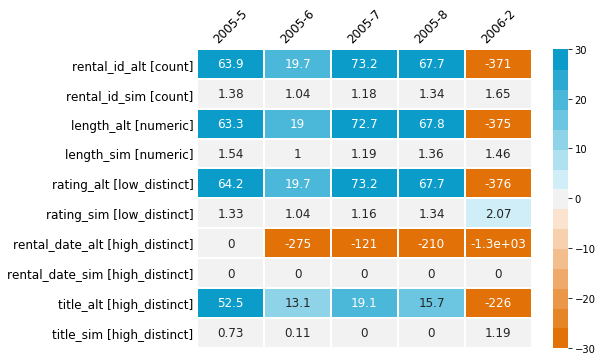

ss_dt,2005-5,2005-6,2005-7,2005-8,2006-2
rental_id_alt [count],63.93,19.690,73.24,67.730,-370.880
rental_id_sim [count],1.38,1.040,1.18,1.340,1.650
length_alt [numeric],63.33,18.960,72.71,67.760,-375.290
length_sim [numeric],1.54,1.000,1.19,1.360,1.460
rating_alt [low_distinct],64.20,19.742,73.19,67.748,-375.752
rating_sim [low_distinct],1.33,1.044,1.16,1.340,2.068
rental_date_alt [high_distinct],0.00,-275.000,-121.43,-210.000,-1300.000
rental_date_sim [high_distinct],0.00,0.000,0.00,0.000,0.000
title_alt [high_distinct],52.48,13.110,19.10,15.660,-225.600
title_sim [high_distinct],0.73,0.110,0.00,0.000,1.190


In [16]:
# Specify table fields - "target" table is first
comparison_fields = ('rental_id','rental_id', 'id')
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')

# Create data gatherer
tester = san.SQLUnitTest(comparison_fields,
                         groupby_fields,
                         table_names,
                         table_alias,
                         db_server='dvd',
                         test_type='count',
                         save_location='results')

# Run count test
tester.run_test()

high_distinct = [('rental_date', 'rental_date', 'rental_date'),
                 ('title', 'title', 'movie')]

# Run high_distinct tests
for comparison_fields in high_distinct:
    tester.comparison_fields = comparison_fields
    tester.test_type = 'high_distinct'
    
    tester.run_test()

# Run low_distinct test
tester.comparison_fields = ('rating','rating', 'rating')
tester.test_type = 'low_distinct'
tester.run_test()

# Run numeric test
tester.comparison_fields = ('length', 'length', 'runtime')
tester.test_type = 'numeric'
tester.run_test()

tester.summarize_results(save_type='image')

In [82]:
tester._summary

In [20]:
tester._priority_review

{'count_alt': 'PRIORITY REVIEW on alt_count: 67.73',
 'rental_date_alt': 'PRIORITY REVIEW on alt_rental_date: 242.5',
 'title_alt': 'PRIORITY REVIEW on alt_title: 19.1'}

### Manage `low_distinct` tests

In [51]:
tester.comparison_fields = ('rating','rating', 'rating')
tester.test_type = 'low_distinct'
tester.run_test()

Commencing test for low_distinct rating...
   Commencing rating query...
   Query for rating complete.
PRIORITY REVIEW on alt_rating: 68.72
Test for rating complete.



In [52]:
tester._results

,date,ss_dt,rvw_rating,rvw_count,alt_count,sim_count,rvw_minus_alt,perc_diff_alt,rvw_minus_sim,perc_diff_sim
0,04-Aug-19,2005-5,G,212,73,210,139,65.57,2,0.94
1,04-Aug-19,2005-5,PG-13,265,115,257,150,56.60,8,3.02
2,04-Aug-19,2005-5,R,227,71,225,156,68.72,2,0.88
3,04-Aug-19,2005-5,NC-17,236,83,235,153,64.83,1,0.42
4,04-Aug-19,2005-5,PG,216,75,213,141,65.28,3,1.39
5,04-Aug-19,2005-6,NC-17,463,382,459,81,17.49,4,0.86
6,04-Aug-19,2005-6,R,479,379,468,100,20.88,11,2.30
7,04-Aug-19,2005-6,PG-13,517,416,515,101,19.54,2,0.39
8,04-Aug-19,2005-6,G,393,308,389,85,21.63,4,1.02
9,04-Aug-19,2005-6,PG,459,371,456,88,19.17,3,0.65


In [56]:
tester._results.fillna(0).groupby('ss_dt')[['perc_diff_alt', 'perc_diff_sim']].mean().replace(0, np.nan).reset_index()

,ss_dt,perc_diff_alt,perc_diff_sim
0,2005-5,64.200,1.330
1,2005-6,19.742,1.044
2,2005-7,73.190,1.160
3,2005-8,67.748,1.340
4,2006-2,-375.752,2.068


<a id='compare'></a>
## Compare IDs

In [47]:
reload(st);

In [3]:
# Specify table fields - "target" table is first
comparison_fields = ('rental_id','rental_id')
groupby_fields = ('ss_dt', 'ss_date')
table_names = ('rental_view', 'alt_rental_view')
table_alias = ('rvw', 'alt')

# Create data gatherer
tester = san.SQLUnitTest(table_names,
                         table_alias,
                         groupby_fields,
                         comparison_fields,
                         db_server='dvd',
                         test_type='id_check')

results = tester.compare_ids(table_alias, comparison_fields)

  Commencing rental_id query...
  Query for rental_id complete.
Commencing count test for rental_id...
  Commencing rental_id query...
  Query for rental_id complete.
PRIORITY REVIEW on rental_id_alt: 67.73
Test for rental_id complete.

Commencing ID comparison for 2005-5 ...
ID comparison for 2005-5 complete.
Commencing ID comparison for 2005-6 ...
ID comparison for 2005-6 complete.
Commencing ID comparison for 2005-7 ...
ID comparison for 2005-7 complete.
Commencing ID comparison for 2005-8 ...
ID comparison for 2005-8 complete.
Commencing ID comparison for 2006-2 ...
ID comparison for 2006-2 complete.


In [4]:
results

,date,rvw_count,alt_count,rvw_minus_alt,perc_diff_alt,rvw_missing_in_alt,missing_rvw_ids,alt_missing_in_rvw,missing_alt_ids
ss_dt,,,,,,,,,
2005-5,17-Aug-19,1156,417,739,63.93,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",1120.0,"[1187, 1336, 1352, 1357, 1420, 1483, 1542, 155...",381.0
2005-6,17-Aug-19,2311,1856,455,19.69,"[1158, 1159, 1160, 1161, 1162, 1163, 1164, 116...",2035.0,"[20, 21, 26, 27, 75, 76, 88, 95, 100, 132, 138...",1580.0
2005-7,17-Aug-19,6709,1795,4914,73.24,"[3470, 3472, 3473, 3474, 3475, 3476, 3477, 347...",5947.0,"[10, 14, 19, 22, 24, 28, 31, 38, 39, 41, 44, 6...",1033.0
2005-8,17-Aug-19,5686,1835,3851,67.73,"[10181, 10182, 10183, 10184, 10185, 10186, 101...",5009.0,"[16, 30, 37, 46, 50, 51, 52, 55, 56, 60, 63, 7...",1158.0
2006-2,17-Aug-19,182,857,-675,-370.88,"[11496, 11541, 12101, 11563, 11577, 11593, 116...",169.0,"[23, 43, 48, 59, 65, 74, 120, 149, 191, 200, 2...",844.0


In [13]:
print(results.loc['2005-5', 'rvw_missing_in_alt'].tolist())

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230

In [35]:
# Specify table fields - "target" table is first
comparison_fields = ('rental_id','rental_id')
groupby_fields = ('ss_dt', 'ss_date')
table_names = ('rental_view', 'alt_rental_view')
table_alias = ('rvw', 'alt')

# Create data gatherer
tester = san.SQLUnitTest(comparison_fields,
                         groupby_fields,
                         table_names,
                         table_alias,
                         db_server='dvd',
                         test_type='id_check')

target_df, source_df = tester.gather_data()

  Commencing rental_id query...
  Query for rental_id complete.


In [36]:
target_df.head()

,ss_dt,rental_id
0,2005-5,2
1,2005-5,3
2,2005-5,4
3,2005-5,5
4,2005-5,6


In [37]:
source_df.head()

,ss_date,rental_id
0,2005-12,2
1,2005-11,3
2,2005-10,4
3,2005-9,5
4,2005-10,6


In [38]:
tester.test_type = 'count'
tester.run_test()

Commencing count test for rental_id...
  Commencing rental_id query...
  Query for rental_id complete.
PRIORITY REVIEW on alt_rental_id: 67.73
Test for rental_id complete.



In [39]:
tester._results

,date,ss_dt,rvw_count,alt_count,rvw_minus_alt,perc_diff_alt
0,10-Aug-19,2005-5,1156,417,739,63.93
1,10-Aug-19,2005-6,2311,1856,455,19.69
2,10-Aug-19,2005-7,6709,1795,4914,73.24
3,10-Aug-19,2005-8,5686,1835,3851,67.73
4,10-Aug-19,2006-2,182,857,-675,-370.88


In [40]:
tester._results.index = tester._results['ss_dt']
tester._results.drop('ss_dt', axis=1, inplace=True)

target_in_source_name = 'rvw_missing_in_alt'
source_in_target_name = 'alt_missing_in_rvw'

tester._results[target_in_source_name] = np.nan
tester._results[source_in_target_name] = np.nan

In [41]:
tester._results.index

Index(['2005-5', '2005-6', '2005-7', '2005-8', '2006-2'], dtype='object', name='ss_dt')

In [44]:
is_ind_target = target_df['ss_dt'] == '2005-5'
is_ind_source = source_df['ss_date'] == '2005-5'

target_in_source = target_df.loc[is_ind_target, 'rental_id']\
                   .isin(source_df.loc[is_ind_source, 'rental_id'])
source_in_target = source_df.loc[is_ind_source, 'rental_id']\
                   .isin(target_df.loc[is_ind_target, 'rental_id'])

In [47]:
target_df.loc[~target_in_source & is_ind_target, 'rental_id'].values.shape[0]

1120

<a id='string'></a>
## Create Test String

In [21]:
reload(san);

# Specify table fields - "target" table is first
comparison_fields = ('rental_id','rental_id', 'id')
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')

# Create data gatherer
tester = san.SQLUnitTest(comparison_fields,
                         groupby_fields,
                         table_names,
                         table_alias,
                         db_server='dvd',
                         test_type='count')

tester.create_test_string()

print(tester._test_str)

tester.gather_data()

WITH rvw AS (SELECT ss_dt, COUNT(*) AS row_count FROM rental_view GROUP BY ss_dt), alt AS (SELECT ss_date, COUNT(*) AS row_count FROM alt_rental_view GROUP BY ss_date), sim AS (SELECT ss_dt, COUNT(*) AS row_count FROM alt_sim_rental_view GROUP BY ss_dt) SELECT rvw.ss_dt, rvw.row_count AS rvw_count, alt.row_count AS alt_count, sim.row_count AS sim_count FROM rvw JOIN alt ON alt.ss_date = rvw.ss_dt JOIN sim ON sim.ss_dt = rvw.ss_dt ORDER BY rvw.ss_dt
  Commencing rental_id query...
  Query for rental_id complete.


,ss_dt,rvw_count,alt_count,sim_count
0,2005-5,1156,417,1140
1,2005-6,2311,1856,2287
2,2005-7,6709,1795,6630
3,2005-8,5686,1835,5610
4,2006-2,182,857,179


<a id='tables'></a>
## Compare Tables

In [23]:
reload(st);

Commencing count test for rental_id...
  Commencing rental_id query...
  Query for rental_id complete.
PRIORITY REVIEW on rental_id_alt: 67.73
Test for rental_id complete.

Commending field type detection...
Field type detection complete.

Commencing high_distinct test for title...
  Commencing title query...
  Query for title complete.
PRIORITY REVIEW on title_alt: 19.1
Test for title complete.

Commencing low_distinct test for rental_date...
  Commencing rental_date query...
  Query for rental_date complete.
PRIORITY REVIEW on rental_date_alt: 88.5
Test for rental_date complete.

Commencing low_distinct test for rating...
  Commencing rating query...
  Query for rating complete.
PRIORITY REVIEW on rating_alt: 68.72
Test for rating complete.

Commencing numeric test for length...
  Commencing length query...
  Query for length complete.
PRIORITY REVIEW on length_alt: 67.76
Test for length complete.



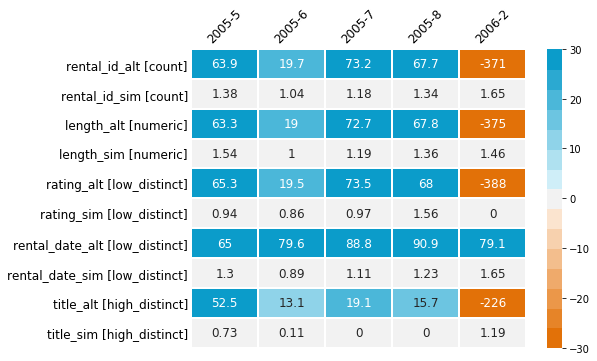

In [8]:
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')
id_fields = ('rental_id','rental_id', 'id')
table_fields = [('rental_date', 'rental_date', 'rental_date'),
                ('title', 'title', 'movie'),
                ('rating','rating', 'rating'),
                ('length', 'length', 'runtime')]

summary, tester = st.compare_tables(table_names, table_alias, groupby_fields,
                                    id_fields, table_fields, 'dvd', 'results',
                                    replace_save=True,
                                    summ_kwargs={'summary_type': 'image', 'save_type': 'image'})

In [9]:
tester._exceptions

{}

In [73]:
tester._results

,date,ss_dt,rvw_count,alt_count,rvw_minus_alt,perc_diff_alt
0,18-Aug-19,2005-5,1156,417,739,63.93
1,18-Aug-19,2005-6,2311,1856,455,19.69
2,18-Aug-19,2005-7,6709,1795,4914,73.24
3,18-Aug-19,2005-8,5686,1835,3851,67.73
4,18-Aug-19,2006-2,182,857,-675,-370.88


In [80]:
tester._priority_review

{'rental_id_alt': 'PRIORITY REVIEW on rental_id_alt: 67.73',
 'rental_date_alt': 'PRIORITY REVIEW on rental_date_alt: 210.0',
 'title_alt': 'PRIORITY REVIEW on title_alt: 19.1',
 'rating_alt': 'PRIORITY REVIEW on rating_alt: 68.72',
 'length_alt': 'PRIORITY REVIEW on length_alt: 67.76'}

<a id='input'></a>
## Input Tests

In [81]:
reload(sqlit);

In [31]:
my_variable = 'abacus'
my_collection = ('a', 'b', 'c')

sqlit.test_in_collection(my_variable, my_collection, 'collection variable')

ValueError: 'abacus' is not a valid collection variable. Use a value from ('a', 'b', 'c').

In [37]:
sqlit.test_input_comp_tables(None, {'save_type': 'both'})

AttributeError: Unable to save results, the 'save_location' attribute is empty. Either add a location to the 'save_location' attribute or use 'save_type' to adjust the summary save options.

In [41]:
sqlit.test_input_ut_ids(['abe', 'abc'], ['1', '3', '2'])

ValueError: Only two fields can be compared at a time when using 'compare_ids'. id_fields contais 3 values.

In [43]:
sqlit.test_input_ut_runtest('id_check')

ValueError: The 'run_test' method cannot be used to complete the 'id_check' test. Please use the 'compare_ids' method instead.

<a id='detect'></a>
## Detect Type

In [45]:
reload(san);

In [18]:
for field in ('rental_id', 'rental_date', 'title', 'rating', 'length'):
    print(field, ':', san.detect_field_type('rental_view', field, 'dvd'))

rental_id : numeric
rental_date : high_distinct
title : high_distinct
rating : low_distinct
length : numeric


In [30]:
fields = ('rental_id', 'rental_date', 'title', 'rating', 'length')
numeric, high_distinct, low_distinct = san.collect_field_type('rental_view', fields, 'dvd')
numeric, high_distinct, low_distinct

(FieldList(test_type='numeric', field_names=['rental_id', 'length']),
 FieldList(test_type='high_distinct', field_names=['rental_date', 'title']),
 FieldList(test_type='low_distinct', field_names=['rating']))

In [32]:
numeric.test_type, numeric.field_names

('numeric', ['rental_id', 'length'])

Commencing count test for rental_id...
  Commencing rental_id query...
  Query for rental_id complete.
PRIORITY REVIEW on rental_id_alt: 67.73
Test for rental_id complete.

Commencing high_distinct test for rental_date...
  Commencing rental_date query...
  Query for rental_date complete.
PRIORITY REVIEW on rental_date_alt: 210.0
Test for rental_date complete.

Commencing high_distinct test for title...
  Commencing title query...
  Query for title complete.
PRIORITY REVIEW on title_alt: 19.1
Test for title complete.

Commencing low_distinct test for rating...
  Commencing rating query...
  Query for rating complete.
PRIORITY REVIEW on rating_alt: 68.72
Test for rating complete.

Commencing numeric test for length...
  Commencing length query...
  Query for length complete.
PRIORITY REVIEW on length_alt: 67.76
Test for length complete.



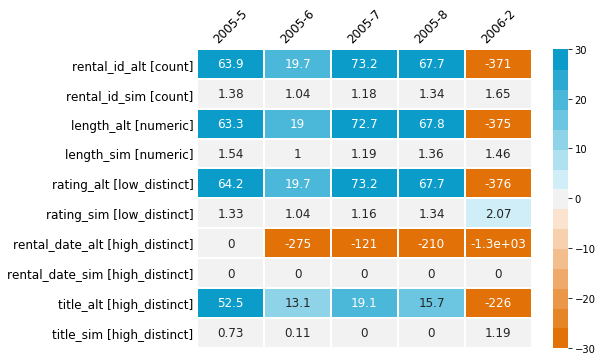

In [3]:
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')
id_fields = ('rental_id','rental_id', 'id')
table_fields = [('rental_date', 'rental_date', 'rental_date'),
                ('title', 'title', 'movie'),
                ('rating','rating', 'rating'),
                ('length', 'length', 'runtime')]

summary, tester = st.compare_tables(table_names, table_alias, groupby_fields,
                                    id_fields, table_fields, 'dvd', 'results', 2)

In [46]:
san.collect_field_name(table_names, 'dvd')

[('index', 'rental_id', 'ss_dt'),
 ('ss_dt', 'rental_date', 'id'),
 ('rental_id', 'title', 'rental_date'),
 ('rental_date', 'length', 'movie'),
 ('title', 'rating', 'runtime'),
 ('length', 'ss_date', 'rating')]

<a id='update'></a>
## Update Attributes

In [36]:
reload(st);

In [37]:
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')
id_fields = ('rental_id','rental_id', 'id')
table_fields = [('rental_date', 'rental_date', 'rental_date'),
                ('title', 'title', 'movie'),
                ('rating','rating', 'rating'),
                ('length', 'length', 'runtime')]
tester = st.SQLTest(table_names, table_alias, groupby_fields, id_fields, 'dvd', 'count')

In [39]:
test_dict = {'comparison_fields': ('title', 'title', 'movie'),
             'test_type': 'high_distinct', 
             '_test_str': "SELECT * FROM rental_view"}

In [13]:
tester.__dict__.update(test_dict)

In [16]:
tester.comparison_fields, tester.table_names, tester.test_type

(('title', 'title', 'movie'),
 ('rental_view', 'alt_rental_view', 'alt_sim_rental_view'),
 'high_distinct')

In [17]:
vars(tester)

{'comparison_fields': ('title', 'title', 'movie'),
 'groupby_fields': ('ss_dt', 'ss_date', 'ss_dt'),
 'table_names': ('rental_view', 'alt_rental_view', 'alt_sim_rental_view'),
 'table_alias': ('rvw', 'alt', 'sim'),
 'db_server': 'dvd',
 'test_type': 'high_distinct',
 'save_location': None,
 '_test_str': None,
 '_results': None,
 '_summary': Empty DataFrame
 Columns: []
 Index: [],
 '_exceptions': {},
 '_priority_review': {},
 '_today_date': '190818',
 '_alt_date': '18-Aug-19'}

In [45]:
tester.update(test_dict)

In [41]:
vars(tester)

{'comparison_fields': ('title', 'title', 'movie'),
 'groupby_fields': ('ss_dt', 'ss_date', 'ss_dt'),
 'table_names': ('rental_view', 'alt_rental_view', 'alt_sim_rental_view'),
 'table_alias': ('rvw', 'alt', 'sim'),
 'db_server': 'dvd',
 'test_type': 'high_distinct',
 'save_location': None,
 '_test_str': 'SELECT * FROM rental_view',
 '_results': None,
 '_summary': Empty DataFrame
 Columns: []
 Index: [],
 '_exceptions': {},
 '_priority_review': {},
 '_today_date': '190818',
 '_alt_date': '18-Aug-19'}

<a id='custom'></a>
## Customize Test String

In [5]:
reload(st);

In [36]:
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')
id_fields = ('rental_id','rental_id', 'id')
table_fields = [('rental_date', 'rental_date', 'rental_date'),
                ('title', 'title', 'movie'),
                ('rating','rating', 'rating'),
                ('length', 'length', 'runtime')]
tester = st.SQLTest(table_names, table_alias, groupby_fields, id_fields, 'dvd', 'count')

In [37]:
tester.create_test_string()
tester._test_str

'WITH rvw AS (SELECT ss_dt, COUNT(*) AS row_count FROM rental_view GROUP BY ss_dt), alt AS (SELECT ss_date, COUNT(*) AS row_count FROM alt_rental_view GROUP BY ss_date), sim AS (SELECT ss_dt, COUNT(*) AS row_count FROM alt_sim_rental_view GROUP BY ss_dt) SELECT rvw.ss_dt, rvw.row_count AS rvw_count, alt.row_count AS alt_count, sim.row_count AS sim_count FROM rvw JOIN alt ON alt.ss_date = rvw.ss_dt JOIN sim ON sim.ss_dt = rvw.ss_dt ORDER BY rvw.ss_dt'

In [7]:
cte_split = tester._test_str.split('),')
cte_split

['WITH rvw AS (SELECT ss_dt, COUNT(*) AS row_count FROM rental_view GROUP BY ss_dt',
 ' alt AS (SELECT ss_date, COUNT(*) AS row_count FROM alt_rental_view GROUP BY ss_date',
 ' sim AS (SELECT ss_dt, COUNT(*) AS row_count FROM alt_sim_rental_view GROUP BY ss_dt) SELECT rvw.ss_dt, rvw.row_count AS rvw_count, alt.row_count AS alt_count, sim.row_count AS sim_count FROM rvw JOIN alt ON alt.ss_date = rvw.ss_dt JOIN sim ON sim.ss_dt = rvw.ss_dt ORDER BY rvw.ss_dt']

In [29]:
pos = 0
table_alias = 'rvw'
for string in cte_split:
    if table_alias + ' AS' in string:
        cte = string
        break
    pos += 1
cte, pos

('WITH rvw AS (SELECT ss_dt, COUNT(*) AS row_count FROM rental_view GROUP BY ss_dt',
 0)

In [15]:
insert_type = 'GROUP BY'
ind = cte.find(insert_type)

In [16]:
first_half = cte[:ind].strip()
second_half = cte[ind:].strip()
first_half, second_half

('WITH rvw AS (SELECT ss_dt, COUNT(*) AS row_count FROM rental_view',
 'GROUP BY ss_dt')

In [19]:
custom = "WHERE ss_dt IN ('2006-2', '2005-10')"
final_string = ' '.join([first_half, custom, second_half])
final_string

"WITH rvw AS (SELECT ss_dt, COUNT(*) AS row_count FROM rental_view WHERE ss_dt IN ('2006-2', '2005-10') GROUP BY ss_dt"

In [26]:
insert_type = 'FROM'
ind = cte.find(insert_type)
ind += cte[ind:].find(' ') + 1
ind += cte[ind:].find(' ')
first_half = cte[:ind].strip()
second_half = cte[ind:].strip()
first_half, second_half

('WITH rvw AS (SELECT ss_dt, COUNT(*) AS row_count FROM rental_view',
 'GROUP BY ss_dt')

In [27]:
custom = "JOIN my_table ON rental_view.ss_dt = my_table.date"
final_string = ' '.join([first_half, custom, second_half])
final_string

'WITH rvw AS (SELECT ss_dt, COUNT(*) AS row_count FROM rental_view JOIN my_table ON rental_view.ss_dt = my_table.date GROUP BY ss_dt'

In [34]:
cte_split[pos] = final_string

query_string = '),'.join(cte_split)
query_string

'WITH rvw AS (SELECT ss_dt, COUNT(*) AS row_count FROM rental_view JOIN my_table ON rental_view.ss_dt = my_table.date GROUP BY ss_dt), alt AS (SELECT ss_date, COUNT(*) AS row_count FROM alt_rental_view GROUP BY ss_date), sim AS (SELECT ss_dt, COUNT(*) AS row_count FROM alt_sim_rental_view GROUP BY ss_dt) SELECT rvw.ss_dt, rvw.row_count AS rvw_count, alt.row_count AS alt_count, sim.row_count AS sim_count FROM rvw JOIN alt ON alt.ss_date = rvw.ss_dt JOIN sim ON sim.ss_dt = rvw.ss_dt ORDER BY rvw.ss_dt'

In [6]:
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')
id_fields = ('rental_id','rental_id', 'id')
table_fields = [('rental_date', 'rental_date', 'rental_date'),
                ('title', 'title', 'movie'),
                ('rating','rating', 'rating'),
                ('length', 'length', 'runtime')]
tester = st.SQLTest(table_names, table_alias, groupby_fields, id_fields, 'dvd', 'count')

tester.create_test_string()
tester.customize_test_string('group_by', "WHERE ss_dt IN {}", tester.table_alias[0], ["('2006-2', '2005-10')"])
tester.customize_test_string('from', "JOIN my_table ON rental_view.ss_dt = my_table.date", tester.table_alias[0])
first_order = tester._test_str

In [7]:
groupby_fields = ('ss_dt', 'ss_date', 'ss_dt')
table_names = ('rental_view', 'alt_rental_view', 'alt_sim_rental_view')
table_alias = ('rvw', 'alt', 'sim')
id_fields = ('rental_id','rental_id', 'id')
table_fields = [('rental_date', 'rental_date', 'rental_date'),
                ('title', 'title', 'movie'),
                ('rating','rating', 'rating'),
                ('length', 'length', 'runtime')]
tester = st.SQLTest(table_names, table_alias, groupby_fields, id_fields, 'dvd', 'count')

tester.create_test_string()
tester.customize_test_string('from', "JOIN my_table ON rental_view.ss_dt = my_table.date", tester.table_alias[0])
tester.customize_test_string('group_by', "WHERE ss_dt IN {}", tester.table_alias[0], ["('2006-2', '2005-10')"])
second_order = tester._test_str

In [8]:
first_order == second_order

True